In [133]:
import csv
import numpy as np
import scipy
import os
import sys
import cvxpy as cp

## Coronavirus Data Exploration

We're doing a bit of open ended exploration of the coronavirus data provided by the New York Times. (https://github.com/nytimes/covid-19-data)

1. Under an initial simplified assumption, we can see how the coronavirus infections will exponentially escalate in the near future

2. Under a more complicated assumption, we can simulate how infections will spread and de-escalate over time. We can use this to show at a high level how government policies on social distancing can potentially affect capacity planning of our medical facilities. (Flatten the Curve: https://www.livescience.com/coronavirus-flatten-the-curve.html)

3. Using parameter estimation techniques we can narrow down on the simulations that reflect our data.

4. We then construct point-in-time forecasts and track the revisions in our projections for total population infected, when the peak arrives, and how big the peak is. We can track these revisions to get a sense of how well government policies are working in certain states.

### Ingestion data snapshot from 20200328

In [134]:
cases_dict={}
deaths_dict={}
flips_dict={}

In [135]:
with open('us-states.csv','r') as fl:
    country_reader=csv.reader(fl)
    for row in country_reader:
        if row[1] not in cases_dict:
            cases_dict[row[1]]=[]
            deaths_dict[row[1]]=[]
            flips_dict[row[1]]=[]
        cases_dict[row[1]].append((row[0],row[3]))
        deaths_dict[row[1]].append((row[0],row[4]))
        flips_dict[row[1]].append((row[0],row[2]))

In [136]:
import datetime

In [137]:
import matplotlib.pyplot as plt

In [138]:
import datetime
days_ca=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['California']]
cases_ca=[int(x[1]) for x in cases_dict['California']]
days_ny=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New York']]
cases_ny=[int(x[1]) for x in cases_dict['New York']]
days_wa=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['Washington']]
cases_wa=[int(x[1]) for x in cases_dict['Washington']]
days_la=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['Louisiana']]
cases_la=[int(x[1]) for x in cases_dict['Louisiana']]
days_nj=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New Jersey']]
cases_nj=[int(x[1]) for x in cases_dict['New Jersey']]

In [139]:
cases_ca=list(np.diff(cases_ca))
cases_ny=list(np.diff(cases_ny))
cases_wa=list(np.diff(cases_wa))
cases_la=list(np.diff(cases_la))
cases_nj=list(np.diff(cases_nj))

We're just looking at the number of infections over time for the different states here. We see New York has been growing much faster than the rest of the population centers. (It's probably due to the fact that NYC is a major travel hub among internation travelers, and many people use the metro system extensively)

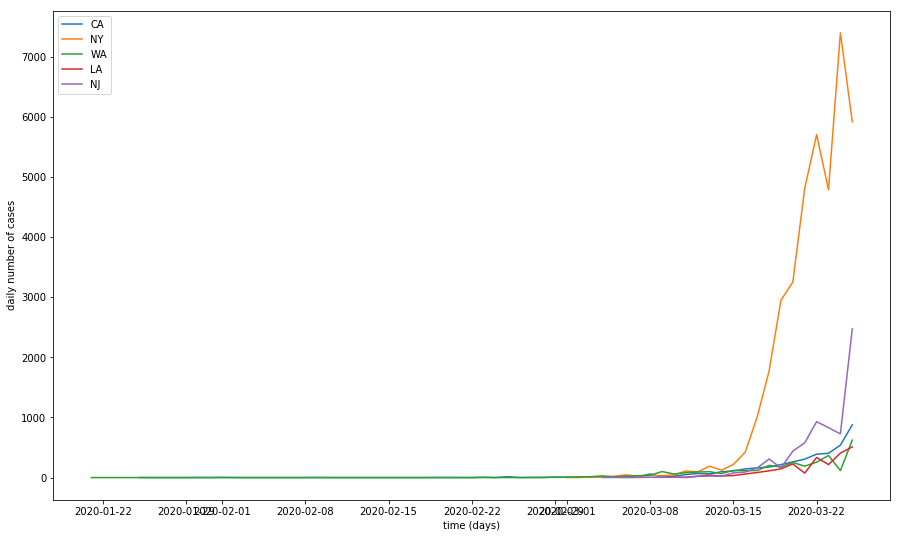

In [140]:
plt.figure(figsize=(15,9))
plt.plot(days_ca[0:-1],cases_ca,label='CA')
plt.plot(days_ny[0:-1],cases_ny,label='NY')
plt.plot(days_wa[0:-1],cases_wa,label='WA')
plt.plot(days_la[0:-1],cases_la,label='LA')
plt.plot(days_nj[0:-1],cases_nj,label='NJ')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

In [141]:
start_date_ca=cases_dict['California'][0][0]
start_date_ny=cases_dict['New York'][0][0]

In [142]:
def date_to_days(base_str_date,input_str_date):
    return (datetime.datetime.strptime(input_str_date,"%Y-%m-%d").date()-datetime.datetime.strptime(base_str_date,"%Y-%m-%d").date()).days

In [143]:
input_data_ca_days=[ date_to_days(start_date_ca,x[0]) for x in cases_dict['California']][0:-1]

In [144]:
input_data_ny_days=[ date_to_days(start_date_ny,x[0]) for x in cases_dict['New York']][0:-1]

### Initial Assumptions

We first assume the infection spreads exponentially. (Assume a world where each person can infect x people. Then those x people each can infect x people...)

In [146]:
from IPython.display import Math
Math(r'y = Ae^{bt}')

<IPython.core.display.Math object>

We will try to fit the exponential curve to our data. By converting our data to a log scale our problem becomes a classic linear least squares regression.

Let's figure out the model for California

In [147]:
A_ca = cp.Variable(pos=True)
b_ca = cp.Variable()

y_ca = np.log(cases_ca[33:])
x_ca = input_data_ca_days[33:]
x_ca = [i - 33 for i in x_ca]
#cost = cp.log_sum_exp( y - A*cp.exp(b*x))
cost_ca = cp.sum_squares( y_ca - A_ca - b_ca*x_ca )
prob_ca = cp.Problem(cp.Minimize(cost_ca))
prob_ca.solve()

#x = cp.Variable(pos=True)
print("\nThe optimal value is", prob_ca.value)
print("The optimal log(A) is")
print(A_ca.value)
print("The optimal b value is")
print(b_ca.value)



The optimal value is 5.95071553015802
The optimal log(A) is
0.8071019354326063
The optimal b value is
0.21963838000177788


In [148]:
print("cases increase by a factor of "+str(A_ca.value)+" every "+str(1/b_ca.value)+" days")

cases increase by a factor of 0.8071019354326063 every 4.552938334328934 days


We plot the log scale fit

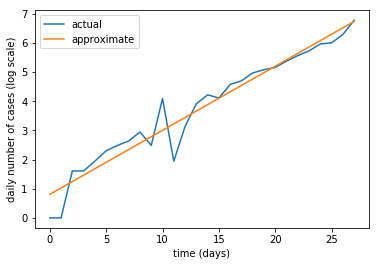

In [149]:
plt.plot(x_ca,y_ca, label='actual')
plt.plot(x_ca, [ A_ca.value + b_ca.value * i for i in x_ca] , label='approximate')
plt.legend()
plt.ylabel('daily number of cases (log scale)')
plt.xlabel('time (days)')
plt.show()

In [150]:
#very good fit

In [151]:
mn=np.mean(y_ca)
res_reg=sum([(mn - A_ca.value - b_ca.value * i)**2 for i in x_ca])
#print(res)
res_tot=sum([(mn - g)**2 for g in y_ca])
print(res_reg/res_tot)

0.9367530899194755


We see the corresponding exponential model is a pretty good fit

In [152]:
def chi_square_approx(E,O,num_bins,dof=1):
    left=min(E)
    right=max(E)
    slices=int((right-left)/num_bins)
    print(slices)
    E_freq=[int(i/slices) for i in E]
    O_freq=[int(i/slices) for i in O]
    E_count={}
    O_count={}
    for i in E_freq:
        if i not in E_count:
            E_count[i]=1
        else:
            E_count[i]+=1
    for i in O_freq:
        if i not in O_count:
            O_count[i]=1
        else:
            O_count[i]+=1
    summ_parts=[]
    
    for key in E_count:
        if key not in O_count:
            O_count[key]=0
        summ_parts.append((E_count[key]-O_count[key])**2/E_count[key])
    print(summ_parts)
    return sum(summ_parts),sum(summ_parts)/(len(E)-dof)

In [153]:
#chi square goodness of fit, 16 bins
E_ca=[ np.exp(A_ca.value) * np.exp(i * b_ca.value) for i in x_ca]
O_ca=np.exp(y_ca)

In [154]:
summ,reduced_chi = chi_square_approx(E_ca,O_ca,16,2)
print(summ,reduced_chi)

52
[0.26666666666666666, 0.3333333333333333, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0]
5.6 0.21538461538461537


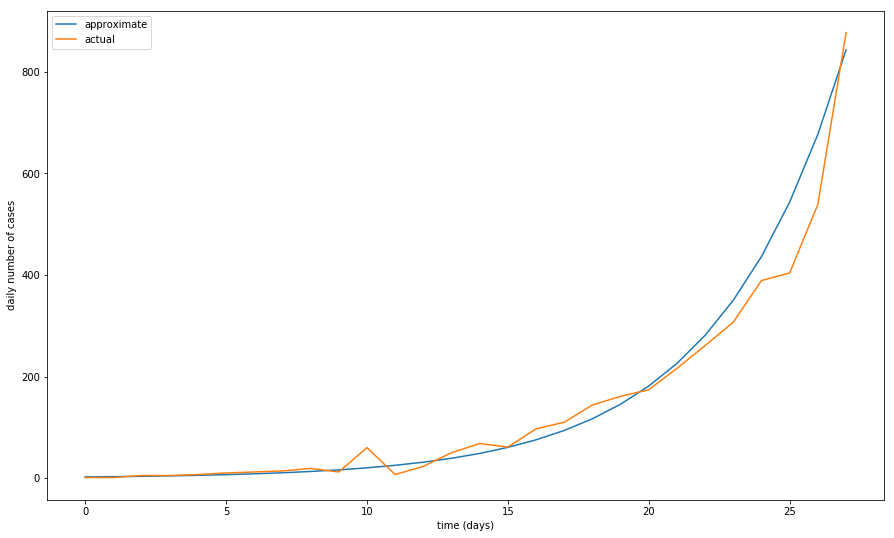

In [156]:
plt.figure(figsize=(15,9))
plt.plot(x_ca, [ np.exp(A_ca.value) * np.exp(i * b_ca.value) for i in x_ca],label='approximate')
plt.plot(x_ca,np.exp(y_ca),label='actual')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

In [130]:

#we don't model on first 30 days because we assume the data is too sparse to draw any conclusions.
#we also get a better fit on the last 60 days.

Let's figure out the model for New York

In [157]:
A_ny = cp.Variable(pos=True)
b_ny = cp.Variable()

cases_ny_sub = [x-0 for x in cases_ny[1:]]#cases_ny[1] for x in cases_ny]
y_ny = np.log(cases_ny_sub[0:])

x_ny = input_data_ny_days[1:]
x_ny = [i - 0 for i in x_ny]
#cost = cp.log_sum_exp( y - A*cp.exp(b*x))
cost_ny = cp.sum_squares( y_ny - A_ny - b_ny*x_ny )
prob_ny = cp.Problem(cp.Minimize(cost_ny))
prob_ny.solve()

#x = cp.Variable(pos=True)
print("\nThe optimal value is", prob_ny.value)
print("The optimal log(A) is")
print(A_ny.value)
print("The optimal b value is")
print(b_ny.value)


The optimal value is 7.0639935297960115
The optimal log(A) is
1.0233614431890665
The optimal b value is
0.3498739107212083


In [158]:
print("cases increase by a factor of "+str(A_ny.value)+" every "+str(1/b_ny.value)+" days")

cases increase by a factor of 1.0233614431890665 every 2.8581725283221666 days


Again, we plot the log scale fit here

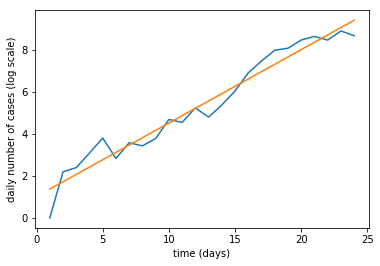

In [159]:
plt.plot(x_ny,y_ny)
plt.plot(x_ny, [ A_ny.value + b_ny.value * i for i in x_ny] )
plt.ylabel('daily number of cases (log scale)')
plt.xlabel('time (days)')
plt.show()

In [160]:
# good fit
mn=np.mean(y_ny)
res_reg=sum([(mn - A_ny.value - b_ny.value * i)**2 for i in x_ny])
#print(res)
res_tot=sum([(mn - g)**2 for g in y_ny])
print(res_reg/res_tot)

0.9522178536929597


The corresponding exponential model here shows us that based on the recent few days, things will escalate quickly

In [161]:
#chi square goodness of fit, 16 bins
E_ny=[ np.exp(A_ny.value) * np.exp(i * b_ny.value) for i in x_ny]
O_ny=np.exp(y_ny)


'\nE_freq=[int(i/500) for i in E]\nO_freq=[int(i/500) for i in O]\nE_count={}\nO_count={}\nfor i in E_freq:\n    if i not in E_count:\n        E_count[i]=1\n    else:\n        E_count[i]+=1\nfor i in O_freq:\n    if i not in O_count:\n        O_count[i]=1\n    else:\n        O_count[i]+=1\nsumm=0\nfor key in E_count:\n    if key not in O_count:\n        O_count[key]=0\n    summ+=(E_count[key]-O_count[key])**2/E_count[key]\nprint(summ,summ/(len(E)-2))\n'

In [162]:
summ,reduced_chi = chi_square_approx(E_ny,O_ny,16,2)
print(summ,reduced_chi)

770
[0.0625, 0.5, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
4.5625 0.20738636363636365


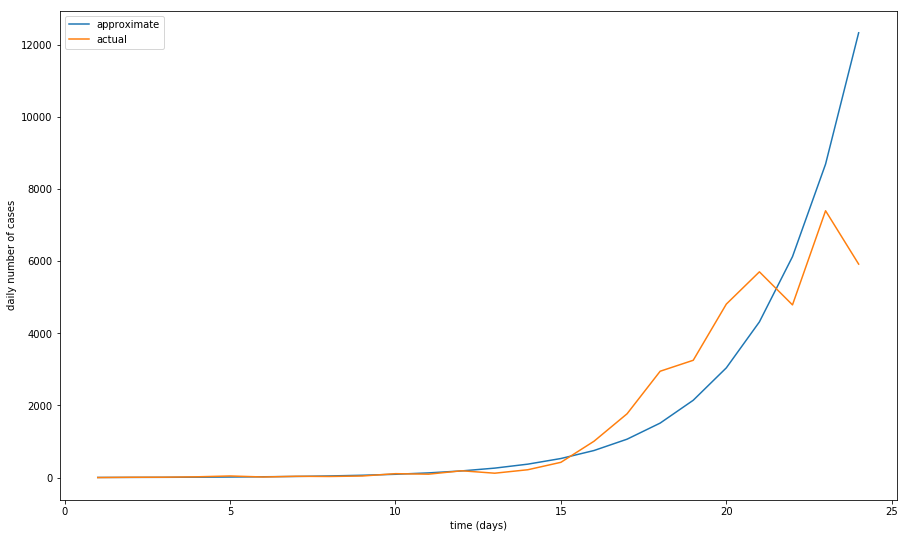

In [163]:
plt.figure(figsize=(15,9))
plt.plot(x_ny, [ np.exp(A_ny.value) * np.exp(i * b_ny.value) for i in x_ny],label='approximate')
plt.plot(x_ny,np.exp(y_ny),label='actual')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

In [136]:
#20 days ago ny was following a different model

We see that in approximately 2 weeks California will reach New York levels of today, but its rate of infection will not surpass New York

In [164]:
len(x_ca)

28

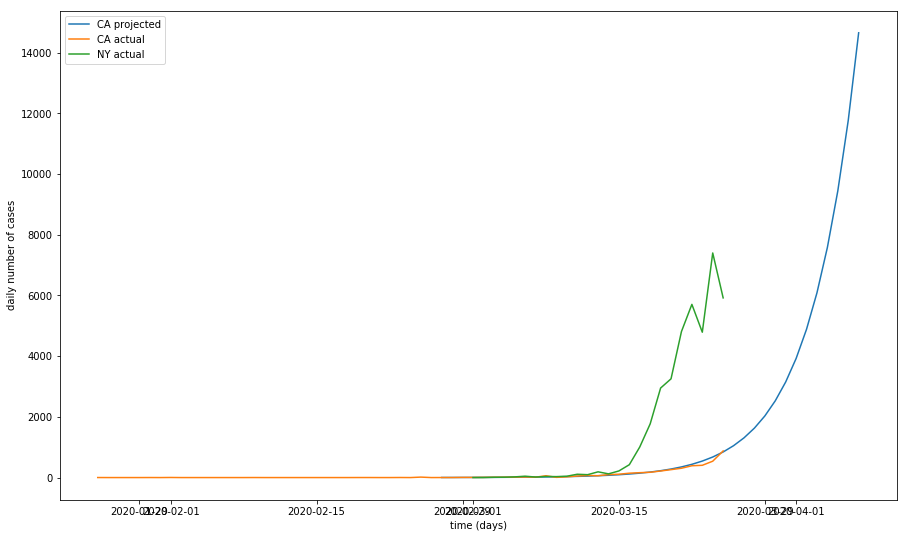

In [165]:
plt.figure(figsize=(15,9))


x_ca_temp=x_ca.copy()
days_ca_sub=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['California']]
for z in range(13):
    days_ca_sub.append(days_ca_sub[-1]+datetime.timedelta(1))
    x_ca_temp.append(x_ca_temp[-1]+1)
input_data_ca_days=[ date_to_days(start_date_ca,x[0]) for x in cases_dict['California'][0:]]#[33:]]
for z in range(13):
    input_data_ca_days.append(input_data_ca_days[-1]+1)
#x_ca = input_data_ca_days[33:]
#x_ca = [i - 33 for i in x_ca]


plt.plot(days_ca_sub[33:-1], [ np.exp(A_ca.value) * np.exp(i * b_ca.value) for i in x_ca_temp],label='CA projected')
#plt.plot(x_ca, [ np.exp(A_ca.value) * np.exp(i * b_ca.value) for i in x_ca],label='approximate')
plt.plot(days_ca[:-1],cases_ca,label='CA actual')
plt.plot(days_ny[:-1],cases_ny,label='NY actual')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

In approximately one week New York will escalate by 5x

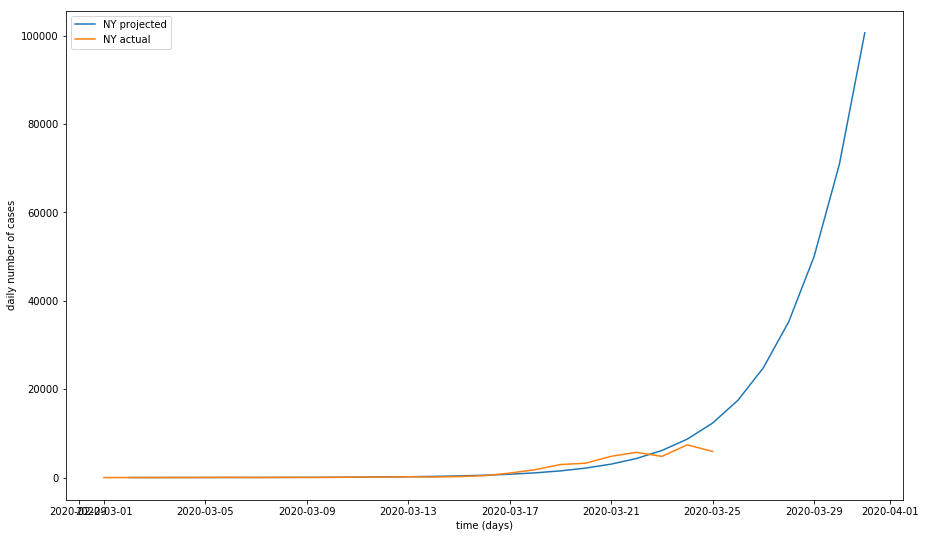

In [166]:
plt.figure(figsize=(15,9))

x_ny_temp=x_ny.copy()
days_ny_sub=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New York']]
for z in range(6):
    days_ny_sub.append(days_ny_sub[-1]+datetime.timedelta(1))
    x_ny_temp.append(x_ny_temp[-1]+1)
input_data_ny_days=[ date_to_days(start_date_ny,x[0]) for x in cases_dict['New York'][0:]]
for z in range(6):
    input_data_ny_days.append(input_data_ny_days[-1]+1)
#x_ny = input_data_ny_days
#x_ny = [i - 20 for i in x_ny]

plt.plot(days_ny_sub[1:-1], [ np.exp(A_ny.value) * np.exp(i * b_ny.value) for i in x_ny_temp],label='NY projected')
plt.plot(days_ny[0:-1],cases_ny,label='NY actual')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()

### Advanced Assumptions

We now assume the infection spreads exponentially, but is dampened by how much population is left to infect over time. We break down the discretization scheme here so we can numerically solve this ODE.

In [167]:
from IPython.display import Math
Math(r'\frac{\partial y}{\partial t} = cy\frac{\int_{t}^{T}y(t)dt - \int_{0}^{t}y(t)dt}{\int_{0}^{T}y(t)dt}')

<IPython.core.display.Math object>

In [209]:
Math(r'y_{t+1} = cy_t\frac{[total - \int_{0}^{t}y(t)dt] - \int_{0}^{t}y(t)dt}{total}+y_t')

<IPython.core.display.Math object>

In [210]:
Math(r'y_{t+1} = cy_t\frac{total - \sum_{i=0}^{t}y_i - \sum_{i=0}^{t}y_i}{total}+y_t')

<IPython.core.display.Math object>

Based on a trapezoidal rule approximation of the integrals, we can instead come up with this:

In [211]:
Math(r'y_{t+1} = cy_t\frac{total - \frac{y_0 + y_t}{2} - \sum_{i=1}^{t-1}y_i - \frac{y_0 + y_t}{2} - \sum_{i=1}^{t-1}y_i}{total}+y_t')

<IPython.core.display.Math object>

We can play around with different parameters:

The total population we expect to get infected over time.

The infection rate c

In [168]:
y_ode = []
y_ode.append(np.exp(y_ca[0]))
pop=2550000
c=0.2
y_ode2 = []
y_ode2.append(np.exp(y_ca[0]))
pop2=2550000
c2=0.3

In [169]:
for i in range(100):
    #numerical integration: trapezoidal rule
    if len(y_ode)==1:
        sum_ode=0.5*y_ode[-1]
        sum_ode2=0.5*y_ode2[-1]
    elif len(y_ode)==2:
        sum_ode=0.5*(y_ode[0]+y_ode[-1])
        sum_ode2=0.5*(y_ode2[0]+y_ode2[-1])
    else:
        sum_ode=0.5*(y_ode[0]+y_ode[-1])+sum(y_ode[1:-1])
        sum_ode2=0.5*(y_ode2[0]+y_ode2[-1])+sum(y_ode2[1:-1])
    y_temp = c*y_ode[-1]*(pop-sum_ode-sum_ode)/pop+y_ode[-1]
    y_ode.append(y_temp)
    y_temp2 = c2*y_ode2[-1]*(pop2-sum_ode2-sum_ode2)/pop2+y_ode2[-1]
    y_ode2.append(y_temp2)

## Flattening the curve

By enacting stay-at-home policices, we can vary the rate of spread of infection to see how it affects the total population over time


Enforcing stay-at-home policies can slow the rate of spread, which lowers the peak of infection. The goal is to keep the peak below the capacity of our medical facilities so society can continue to function without our health care systems falling apart.

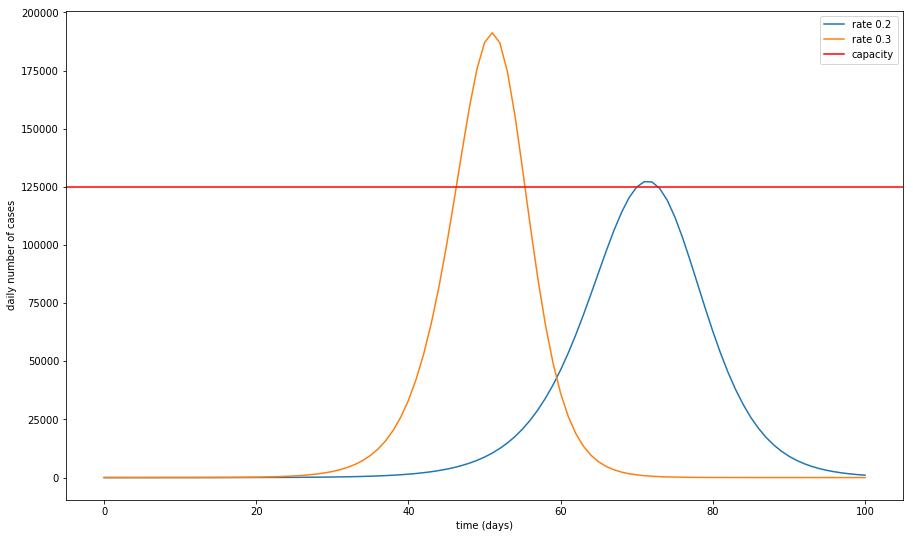

In [170]:
plt.figure(figsize=(15,9))
plt.plot(y_ode,label='rate 0.2')
plt.plot(y_ode2,label='rate 0.3')
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.axhline(y=125000,color='r',label='capacity')
plt.legend()
plt.show()

By enacting stay-at-home policices, we can also reduce the total population infected down the road, which also would affect the curve over time.


This would also lower the peak of infection.

In [171]:
y_ode3 = []
y_ode3.append(np.exp(y_ca[0]))
pop3=2550000# Number of new yorkers to be infected according to DeBlasio
c3=0.3
y_ode4 = []
y_ode4.append(np.exp(y_ca[0]))
pop4=1550000# Number of new yorkers to be infected according to DeBlasio
c4=0.3

In [172]:
for i in range(100):
    if len(y_ode3)==1:
        sum_ode3=0.5*y_ode3[-1]
        sum_ode4=0.5*y_ode4[-1]
    elif len(y_ode3)==2:
        sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])
        sum_ode4=0.5*(y_ode4[0]+y_ode4[-1])
    else:
        sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])+sum(y_ode3[1:-1])
        sum_ode4=0.5*(y_ode4[0]+y_ode4[-1])+sum(y_ode4[1:-1])
    y_temp3 = c3*y_ode3[-1]*(pop3-sum_ode3-sum_ode3)/pop3+y_ode3[-1]
    y_ode3.append(y_temp3)
    y_temp4 = c4*y_ode4[-1]*(pop4-sum_ode4-sum_ode4)/pop4+y_ode4[-1]
    y_ode4.append(y_temp4)

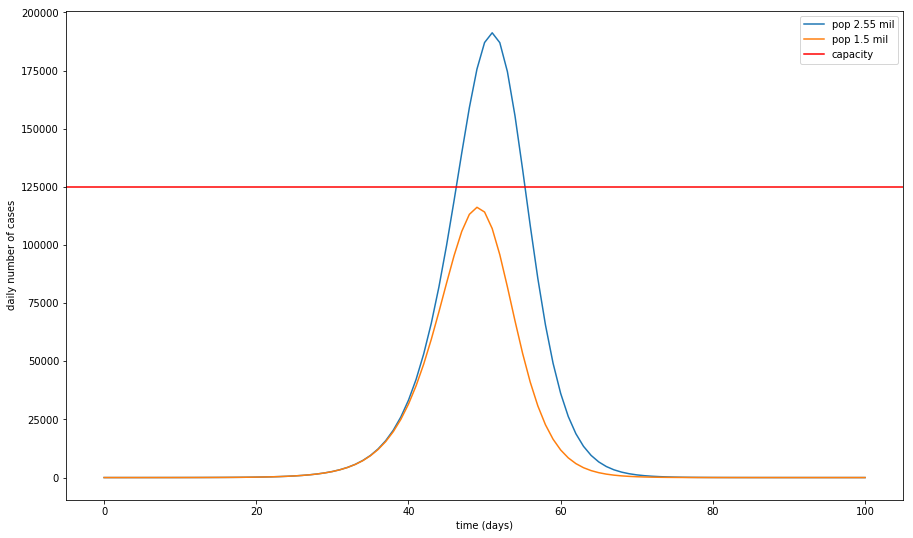

In [173]:
plt.figure(figsize=(15,9))
plt.plot(y_ode3,label='pop 2.55 mil')
plt.plot(y_ode4,label='pop 1.5 mil')
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.axhline(y=125000,color='r',label='capacity')
plt.legend()
plt.show()

Government efforts could also reduce infection rate and the overall infected population.

In [174]:
y_ode3 = []
y_ode3.append(np.exp(y_ca[0]))
pop3=2550000# Number of new yorkers to be infected according to DeBlasio
c3=0.3
y_ode4 = []
y_ode4.append(np.exp(y_ca[0]))
pop4=1550000# Number of new yorkers to be infected according to DeBlasio
c4=0.2

In [175]:
for i in range(100):
    if len(y_ode3)==1:
        sum_ode3=0.5*y_ode3[-1]
        sum_ode4=0.5*y_ode4[-1]
    elif len(y_ode3)==2:
        sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])
        sum_ode4=0.5*(y_ode4[0]+y_ode4[-1])
    else:
        sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])+sum(y_ode3[1:-1])
        sum_ode4=0.5*(y_ode4[0]+y_ode4[-1])+sum(y_ode4[1:-1])
    y_temp3 = c3*y_ode3[-1]*(pop3-sum_ode3-sum_ode3)/pop3+y_ode3[-1]
    y_ode3.append(y_temp3)
    y_temp4 = c4*y_ode4[-1]*(pop4-sum_ode4-sum_ode4)/pop4+y_ode4[-1]
    y_ode4.append(y_temp4)

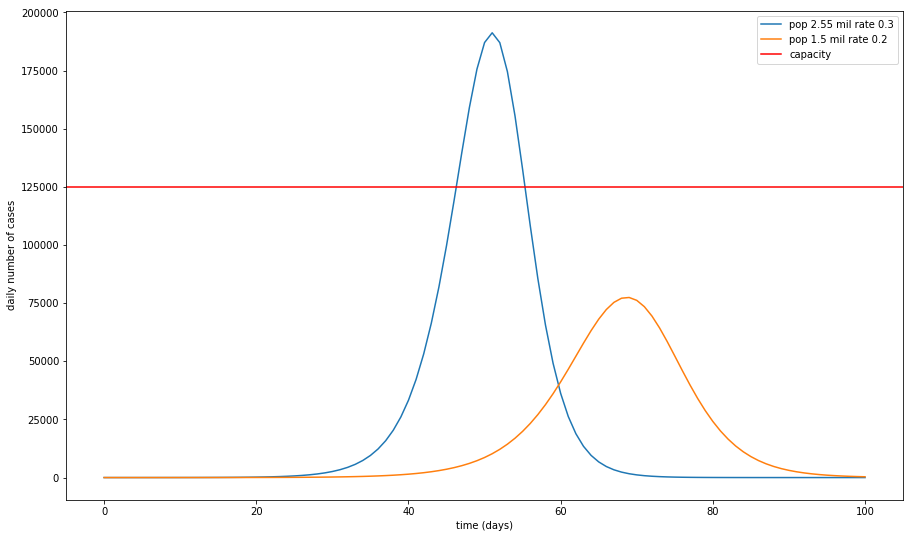

In [176]:
plt.figure(figsize=(15,9))
plt.plot(y_ode3,label='pop 2.55 mil rate 0.3')
plt.plot(y_ode4,label='pop 1.5 mil rate 0.2')
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.axhline(y=125000,color='r',label='capacity')
plt.legend()
plt.show()

### Parameter Estimation of ODE's

Now that we have a feel for the different simulations under our given ODE above, we will try to estimate the parameters of population size and infection rate that best fits our data.

1. We can try fitting through the IVP approach. 

a) Start with your initial/boundary conditions.

b) Make a guess for your parameters.

c) Run your ODE simulation based on your parameters.

d) Measure the error between your data points and your simulated points. Terminate if error is within a threshold. Repeat b-d if not.

We iterate on our guesses based on gradient descent, where we sample the error at different points around our iteration, then we pick the next guess based on the greatest decrease in error. We will later also add a penalty term for certain parameters if there's a lack of concavity with respect to those parameters.

In [186]:
cases_ca_temp=cases_ca[33:]


## CA optimization

In [193]:
def sim(params,cases_data):
    pop3=params[0]
    c3=params[1]
    y_ode3 = []
    y_ode3.append(cases_data[0])#np.exp(y_ca[0]))
    the_max=cases_data[0]
    it=0
    day_of_peak=it
    
    for i in range(100):
        if len(y_ode3)==1:
            sum_ode3=0.5*y_ode3[-1]#+0.5*cases_ny[0]+sum(cases_ny[1:13])

        elif len(y_ode3)==2:
            sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])#+0.5*cases_ny[0]+sum(cases_ny[1:13])+y_ode3[0]*0.5

        else:
            sum_ode3=0.5*(y_ode3[0]+y_ode3[-1])+sum(y_ode3[1:-1])#+0.5*cases_ny[0]+sum(cases_ny[1:13])+y_ode3[0]*0.5

        y_temp3 = c3*y_ode3[-1]*(pop3-sum_ode3-sum_ode3)/pop3+y_ode3[-1]
        y_ode3.append(y_temp3)
        it=it+1
        
        if y_temp3 > the_max:
            the_max = y_temp3
            day_of_peak=it
            
    return y_ode3, the_max, day_of_peak

In [195]:
y_out,maxx,daofpeak=sim([500000,0.25],cases_ny[0:])

In [196]:
def approximate_optimize(init_guess,func,data):
    penalty_pop=0.0003
    err_trajectory=[]
    parm_trajectory=[]
    parms=init_guess
    for i in range(60):
        y_preds,y_max,y_day=func(parms,data)
        err=sum((np.array(data)-np.array(y_preds[0:len(data)]))**2)+parms[0]*np.abs(penalty_pop)
        err_trajectory.append(err)
        parm_trajectory.append(parms)
        rand_prms=[]
        val_rand_prms=[]
        
        #approximate gradient by sampling points
        for j in range(25):
            mean=parms
            cov=[[4200000000,0],[0,0.002]]
            #randomly guess
            #rand_prms.append(list(np.random.multivariate_normal(mean, cov, (1, 1))[0][0]))
            rand_prms.append([np.random.normal(mean[0],40000,1)[0],np.random.normal(mean[-1],0.005,1)[0]])
            y_preds_j, y_max_j, y_day_j = func(rand_prms[-1],data)
            err_j=sum((np.array(data)-np.array(y_preds_j[0:len(data)]))**2)+rand_prms[-1][0]*np.abs(penalty_pop)
            val_rand_prms.append((err_j-err))#-penalty_pop*(rand_prms[-1][0]-parms[0]))
        
        min_idx=val_rand_prms.index(min(val_rand_prms))
        parms=rand_prms[min_idx]
    return parms,err_trajectory,parm_trajectory

In [197]:
def approximate_optimize_monte_carlo(starting_guess,optimal_offset,cases):
    pop_distribution=[]
    rate_distribution=[]
    peak_distribution=[]
    err_distribution=[]
    for i in range(100):
        #print(i)
        prm,err_list,prm_iter=approximate_optimize(starting_guess,sim,cases[optimal_offset:])
        pop_distribution.append(prm[0])
        err_distribution.append(err_list[-1])
        rate_distribution.append(prm[1])
        y_out,the_max,y_day=sim(prm,cases[optimal_offset:])
        peak_distribution.append(the_max)
    return pop_distribution,rate_distribution,peak_distribution,err_distribution

In [199]:

pop_distribution,rate_distribution,peak_distribution,err_distribution = approximate_optimize_monte_carlo([1000000,0.4],33,cases_ca[0:])

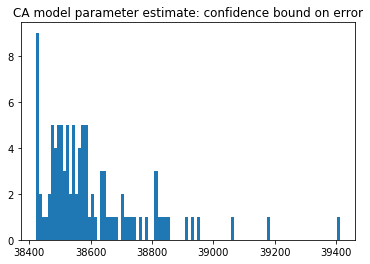

In [201]:
a=plt.hist(err_distribution,bins=100)
plt.title("CA model parameter estimate: confidence bound on error")
plt.show()

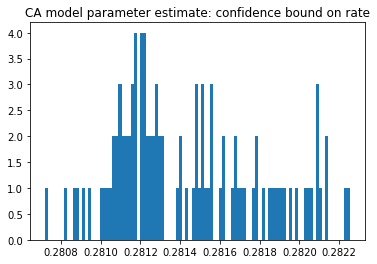

In [202]:
b=plt.hist(rate_distribution,bins=100)
plt.title("CA model parameter estimate: confidence bound on rate")
plt.show()

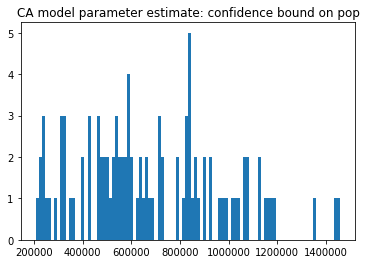

In [203]:
c=plt.hist(pop_distribution,bins=100)
plt.title("CA model parameter estimate: confidence bound on pop")
plt.show()

We can see with this tight bound on rate and loose bound on pop that the objective function has been convex w.r.t rate and not convex w.r.t population. Hence why we needed to add a penalty term for population

In [1027]:
np.mean(rate_distribution)

0.2813398679928285

In [1016]:
prm,err_list,prm_iter=approximate_optimize([1000000,0.4],sim,cases_ca[33:])

Here we figure out how many points in the beginning to discard, as it can have a big impact on our forecasts. We search over different offsets to find out which ones give us a small error (treated as [regret](https://cs.nyu.edu/~mohri/talks/MIT2017.pdf)) in general

In [477]:
params_values=[]
for pops in [10]:
    pop=pops*100000
    for offset in [0,1,3,5,8,10,12,15,18,20,25,29,30,33]:
        try:
            prm,err_list,prm_iter=approximate_optimize([pop,0.4],sim,cases_ca[offset:])
            print(str(pop)+" "+str(offset)+" err "+str(err_list[-1]))
            params_values.append((prm[0],prm[1],offset,err_list[-1]))
        except:
            print("out of range")

/Users/vibhorjain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/Users/vibhorjain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square


100000 0 err 5272146.161422294
100000 1 err 1697966.0
100000 3 err 1697966.0
100000 5 err 1881983.6631188202
100000 10 err 1697956.0
100000 12 err 1697956.0
100000 15 err 3607924.4018124375
100000 18 err 1697955.0
100000 20 err 1697955.0
100000 25 err 2134051.1990631423
100000 29 err 17287491.017133817
100000 30 err 1697949.0
100000 33 err 2386582.131444484
200000 0 err 1709348.1679648384
200000 1 err 1697966.0
200000 3 err 1697966.0
200000 5 err 6820850.111987597
200000 10 err 1697956.0
200000 12 err 1697956.0
200000 15 err 2785609.2256590324
200000 18 err 1697955.0
200000 20 err 1697955.0
200000 25 err 6795382.256143447
200000 29 err 32421543.030540694
200000 30 err 1697949.0
200000 33 err 864480.9414707845
300000 0 err 1858897.9510427094
300000 1 err 1697966.0
300000 3 err 1697966.0
300000 5 err 2991007.3944088295
300000 10 err 1697956.0
300000 12 err 1697956.0
300000 15 err 1699619.8173191804
300000 18 err 1697955.0
300000 20 err 1697955.0
300000 25 err 2087287.33795369
300000 29 e

In [409]:
params_values.sort(key = lambda x: x[3])

In [410]:
params_values

[(1097440.9632263915, 0.28108286470935867, 33, 38307.59521506698),
 (698944.4807891635, 0.2818844220854187, 33, 38309.5867261345),
 (1196044.4530862246, 0.28287183726447995, 33, 38327.96992029968),
 (307408.7460926289, 0.28107508637380135, 33, 38421.31093648971),
 (593401.8816563524, 0.28015716212122915, 33, 38454.716905475965),
 (1001177.1073850738, 0.28196721065656993, 33, 38486.42355572505),
 (1401832.401654146, 0.27838366034462403, 33, 38531.21697626417),
 (501989.40372555924, 0.27962636216990316, 33, 38576.34664954619),
 (1297937.3246545508, 0.2805811423649715, 33, 38632.27781893101),
 (199199.75781330632, 0.28225348430014474, 33, 38773.98935729111),
 (401206.9979306743, 0.283240688907805, 33, 38799.39600744483),
 (102890.24061473865, 0.2837360761127227, 33, 38819.258433250165),
 (902516.8416621956, 0.27986672863425643, 33, 39380.5786999455),
 (805751.0808032738, 0.28206073869466525, 33, 39861.091112829716),
 (804212.0910583687, 0.2087774969186775, 29, 41121.65915988106),
 (139821

In [1030]:
#prm=[params_values[3][0],params_values[3][1]]
#optimal_offset=params_values[3][2]
#y_out=sim(prm,cases_ca[optimal_offset:])
guess=[680000,0.2813]
y_out,maxx=sim(guess,cases_ca[optimal_offset:])

Based on our parameter search for offset, total population, and infection rate we make an educated guess and run the simulation to visually inspect how well it agrees with our data

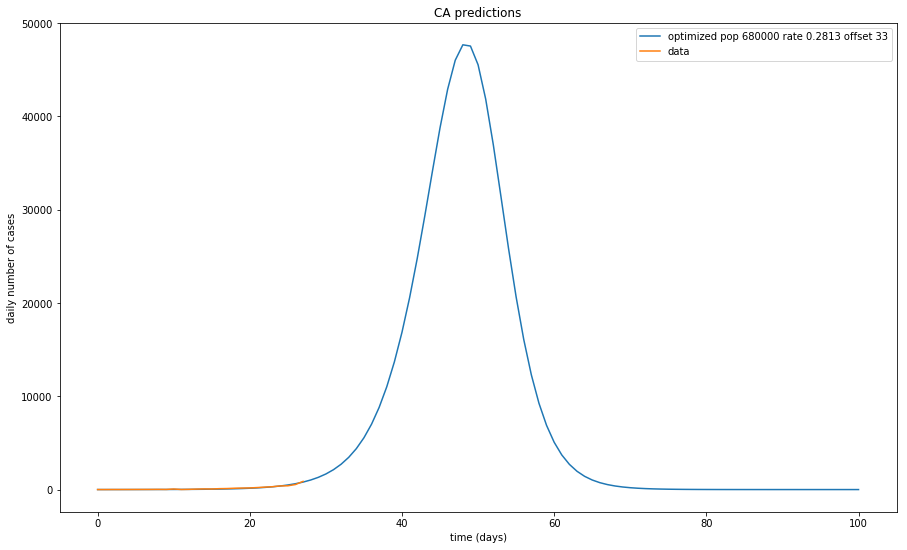

In [1033]:
plt.figure(figsize=(15,9))
#plt.plot(y_odef,label='pop '+str(res.x[1])+' mil rate '+str(res.x[0]))
#plt.plot(y_ode3,label='guesstimate')
plt.title('CA predictions')
plt.plot(y_out,label='optimized pop '+str(guess[0])+" rate "+str(guess[1])+" offset "+str(optimal_offset))
plt.plot(cases_ca[optimal_offset:],label='data')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()
#do grid search with multiple discarding starting points, multiple initial population size

In [ ]:
#best fit ode for california has infection rate rate 0.2155 and total population infected: 202000, 
#peak is after 44 day mark (+29 offset), so 73 days after 2020-01-25 -> 2020-04-8
#peak is at 10889 infected

## NY Optimization

In [205]:
   
pop_distribution,rate_distribution,peak_distribution,err_distribution = approximate_optimize_monte_carlo([2500000,0.25],3,cases_ny[0:-1])

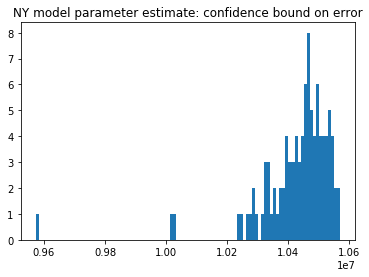

In [206]:
a=plt.hist(err_distribution,bins=100)
plt.title("NY model parameter estimate: confidence bound on error")
plt.show()

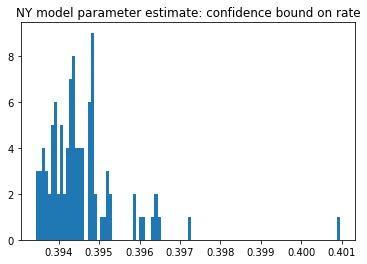

In [207]:
b=plt.hist(rate_distribution,bins=100)
plt.title("NY model parameter estimate: confidence bound on rate")
plt.show()

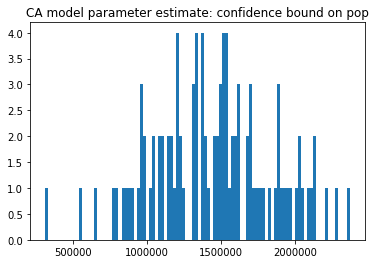

In [208]:
c=plt.hist(pop_distribution,bins=100)
plt.title("CA model parameter estimate: confidence bound on pop")
plt.show()

In [1179]:
prm,err_list,prm_iter=approximate_optimize([2500000,0.25],sim,cases_ny[3:-1])

Here we figure out how many points in the beginning to discard, as it can have a big impact on our forecasts. We search over different offsets to find out which ones give us a small error (treated as treated as [regret](https://cs.nyu.edu/~mohri/talks/MIT2017.pdf)) in general

In [1035]:
params_values=[]
for pops in [10]:
    pop=pops*100000
    for offset in [0,1,3,5,8,10,12,15,18,20,25,29,30,33]:
        try:
            prm,err_list,prm_iter=approximate_optimize([pop,0.4],sim,cases_ny[offset:])
            print(str(pop)+" "+str(offset)+" err "+str(err_list[-1]))
            params_values.append((prm[0],prm[1],offset,err_list[-1]))
        except:
            print("out of range")

1000000 0 err 192247259.47595334


/Users/vibhorjain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/Users/vibhorjain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in square


1000000 1 err 11948974.446550129
1000000 3 err 4103509.0059571057
1000000 5 err 5580727.168691785
1000000 8 err 5754608.146316441
1000000 10 err 4075467.9869451323
1000000 12 err 4284590.070352509
1000000 15 err 9348651.84013329
1000000 18 err 3126005.3286219314
1000000 20 err 2894158.088145756
out of range
out of range
out of range
out of range


In [1036]:
params_values.sort(key = lambda x: x[3])

In [1037]:
params_values

[(37275.31534408571, 0.12754885163136617, 20, 2894158.088145756),
 (49215.75721658315, 0.2599773339144455, 18, 3126005.3286219314),
 (50303.9476871866, 0.499210874050633, 10, 4075467.9869451323),
 (60527.13554660408, 0.4488083654767057, 3, 4103509.0059571057),
 (49841.09090456073, 0.5283702163341786, 12, 4284590.070352509),
 (62469.61951354882, 0.4069787679352547, 5, 5580727.168691785),
 (47936.56135729183, 0.5488813934168846, 8, 5754608.146316441),
 (46558.49433875977, 0.5738330397003514, 15, 9348651.84013329),
 (46674.774405135104, 0.5750630597993168, 1, 11948974.446550129),
 (-3610894.1856577736, 0.4081304304287639, 0, 192247259.47595334)]

In [1169]:
#prm=[params_values[3][0],params_values[3][1]]
optimal_offset=params_values[3][2]
#y_out=sim([params_values[3][0],params_values[3][1]],cases_ny[optimal_offset:])
guess=[1405873,0.395]#[1200000,0.40]
y_out,maxx=sim(guess,cases_ny[optimal_offset:])

Based on our parameter search for offset, total population, and infection rate we make an educated guess and run the simulation to visually inspect how well it agrees with our data

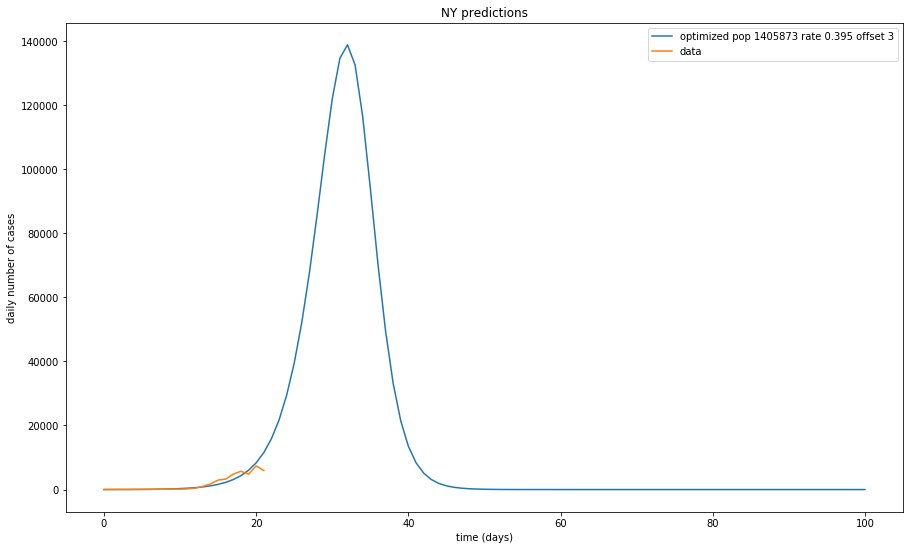

In [1170]:
plt.figure(figsize=(15,9))
#plt.plot(y_odef,label='pop '+str(res.x[1])+' mil rate '+str(res.x[0]))
#plt.plot(y_ode3,label='guesstimate')
plt.title('NY predictions')
plt.plot(y_out,label='optimized pop '+str(guess[0])+" rate "+str(guess[1])+" offset "+str(optimal_offset))
plt.plot(cases_ny[optimal_offset:],label='data')
plt.legend()
plt.ylabel('daily number of cases')
plt.xlabel('time (days)')
plt.show()
#do grid search with multiple discarding starting points, multiple initial population size

In [ ]:
#best fit ode for new york has infection rate 0.33 and total population infected 650000
#peak is after 11 day mark (+20 offset), so 33 days after 2020-03-01 -> 2020-04-2
#peak for new york is at 65207

### Point-In-Time Parameter Estimates and Simulations

For each day, we will see a change in infection data (addition of a new day, and/or revision of old days.). We make a forecast on each revision of our data and track those forecast revisions.

In [219]:
def process_PIT_time_series(fname):
    print("doing sim and optimization for "+fname)
    cases_dict={}
    deaths_dict={}
    flips_dict={}
    
    with open(fname,'r') as fl:
        country_reader=csv.reader(fl)
        for row in country_reader:
            if row[1] not in cases_dict:
                cases_dict[row[1]]=[]
                deaths_dict[row[1]]=[]
                flips_dict[row[1]]=[]
            cases_dict[row[1]].append((row[0],row[3]))
            deaths_dict[row[1]].append((row[0],row[4]))
            flips_dict[row[1]].append((row[0],row[2]))
            
    days_ca=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['California']]
    cases_ca=[int(x[1]) for x in cases_dict['California']]
    days_ny=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New York']]
    cases_ny=[int(x[1]) for x in cases_dict['New York']]
    days_wa=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['Washington']]
    cases_wa=[int(x[1]) for x in cases_dict['Washington']]
    days_la=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['Louisiana']]
    cases_la=[int(x[1]) for x in cases_dict['Louisiana']]
    days_nj=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New Jersey']]
    cases_nj=[int(x[1]) for x in cases_dict['New Jersey']]
    
    cases_ca=list(np.diff(cases_ca))
    cases_ny=list(np.diff(cases_ny))
    cases_wa=list(np.diff(cases_wa))
    cases_la=list(np.diff(cases_la))
    cases_nj=list(np.diff(cases_nj))
    

    start_date_ca=cases_dict['California'][0][0]
    start_date_ny=cases_dict['New York'][0][0]
    
    input_data_ca_days=[ date_to_days(start_date_ca,x[0]) for x in cases_dict['California']][0:-1]
    input_data_ny_days=[ date_to_days(start_date_ny,x[0]) for x in cases_dict['New York']][0:-1]
    
    y_ca = np.log(cases_ca[33:])
    x_ca = input_data_ca_days[33:]
    x_ca = [i - 33 for i in x_ca]
    
    cases_ny_sub = [x-0 for x in cases_ny[1:]]#cases_ny[1] for x in cases_ny]
    y_ny = np.log(cases_ny_sub[0:])

    x_ny = input_data_ny_days[1:]
    x_ny = [i - 0 for i in x_ny]
        
    pop_distribution,rate_distribution,peak_distribution,err_distribution = approximate_optimize_monte_carlo([1000000,0.4],33,cases_ca[0:])
    guess_ca=[np.mean(pop_distribution),np.mean(rate_distribution)]#[1200000,0.40]
    y_out_ca,max_ca,day_ca=sim(guess_ca,cases_ca[33:])
    peak_ca=np.mean(peak_distribution)
    err_ca=np.mean(err_distribution)
    
    pop_distribution,rate_distribution,peak_distribution,err_distribution = approximate_optimize_monte_carlo([2500000,0.25],3,cases_ny[0:-1])
    guess_ny=[np.mean(pop_distribution),np.mean(rate_distribution)]#[1200000,0.40]
    y_out_ny,max_ny,day_ny=sim(guess_ny,cases_ny[3:])
    peak_ny=np.mean(peak_distribution)
    err_ny=np.mean(err_distribution)
    
    return y_out_ca,y_out_ny,guess_ca,guess_ny,peak_ca,peak_ny,day_ca,day_ny,err_ca,err_ny

In [220]:
files=[
    '../../coronavirus_repo_vjain3/covid19_exploration/20200327/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200328/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200329/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200330/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200331/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200401/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200402/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200403/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200404/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200405/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200406/covid-19-data/us-states.csv',
    '../../coronavirus_repo_vjain3/covid19_exploration/20200407/covid-19-data/us-states.csv'
]

In [221]:
ca_sims=[]
ny_sims=[]
ca_pops=[]
ny_pops=[]
ca_rates=[]
ny_rates=[]
ca_peaks=[]
ny_peaks=[]
ca_days=[]
ny_days=[]
ca_errs=[]
ny_errs=[]

for fl in files:
    y_out_ca,y_out_ny,guess_ca,guess_ny,peak_ca,peak_ny,day_ca,day_ny,err_ca,err_ny=process_PIT_time_series(fl)
    ca_sims.append(y_out_ca)
    ny_sims.append(y_out_ny)
    ca_pops.append(guess_ca[0])
    ny_pops.append(guess_ny[0])
    ca_rates.append(guess_ca[1])
    ny_rates.append(guess_ny[1])
    ca_peaks.append(peak_ca)
    ny_peaks.append(peak_ny)
    ca_days.append(day_ca)
    ny_days.append(day_ny)
    ca_errs.append(err_ca)
    ny_errs.append(err_ny)

doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200327/covid-19-data/us-states.csv


/Users/vibhorjain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars


doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200328/covid-19-data/us-states.csv


/Users/vibhorjain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in square


doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200329/covid-19-data/us-states.csv
doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200330/covid-19-data/us-states.csv
doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200331/covid-19-data/us-states.csv
doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200401/covid-19-data/us-states.csv
doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200402/covid-19-data/us-states.csv
doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200403/covid-19-data/us-states.csv
doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200404/covid-19-data/us-states.csv
doing sim and optimization for ../../coronavirus_repo_vjain3/covid19_exploration/20200405/covid-19-data/us-states.csv
doing sim and optimization for ../../coronavirus_repo_vj

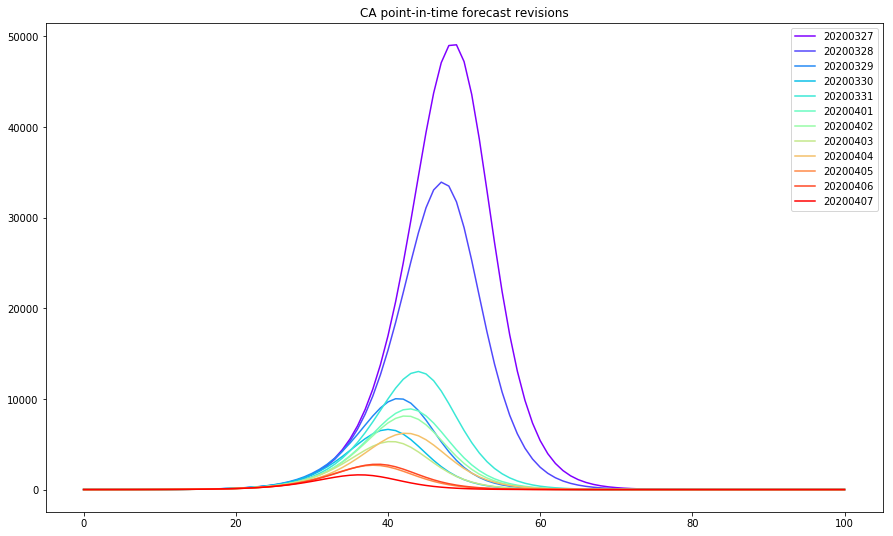

In [222]:
from matplotlib.pyplot import cm
NUM_COLORS = len(ca_sims)
#cm = plt.get_cmap('gist_rainbow')
color=cm.rainbow(np.linspace(0,1,NUM_COLORS))

#ax = plt.figure()
#ax = fig.add_subplot(111)
#ax.set_prop_cycle(label=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
plt.figure(figsize=(15,9))
plt.title('CA point-in-time forecast revisions')
for sm in range(len(ca_sims)):
    lbl=files[sm].split('/')[-3]
    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
plt.legend()
plt.show()

We can see that as we gather more data over time, projections over total population infected and peak infection have significantly decreased, indicating that stay-at-home measures are indeed 'flattening the curve'

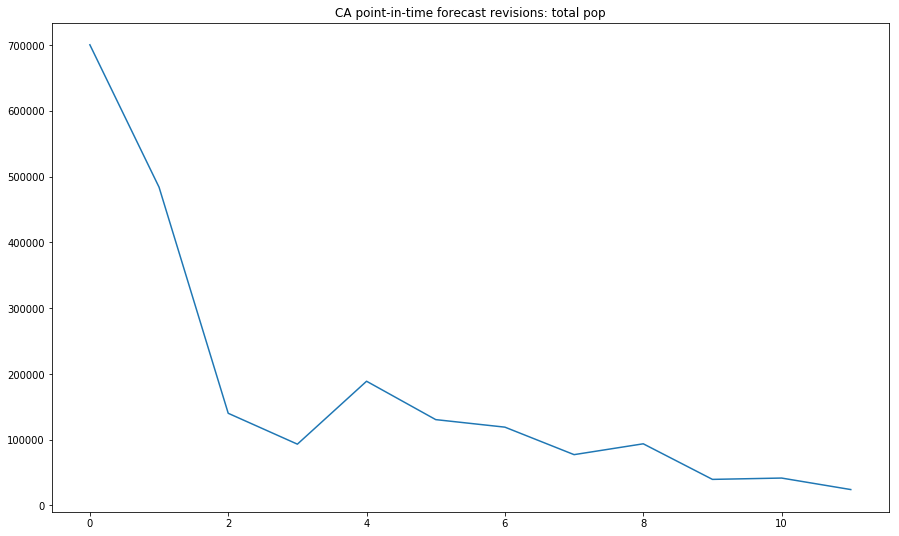

In [223]:
plt.figure(figsize=(15,9))
plt.title('CA point-in-time forecast revisions: total pop')
plt.plot(ca_pops)
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

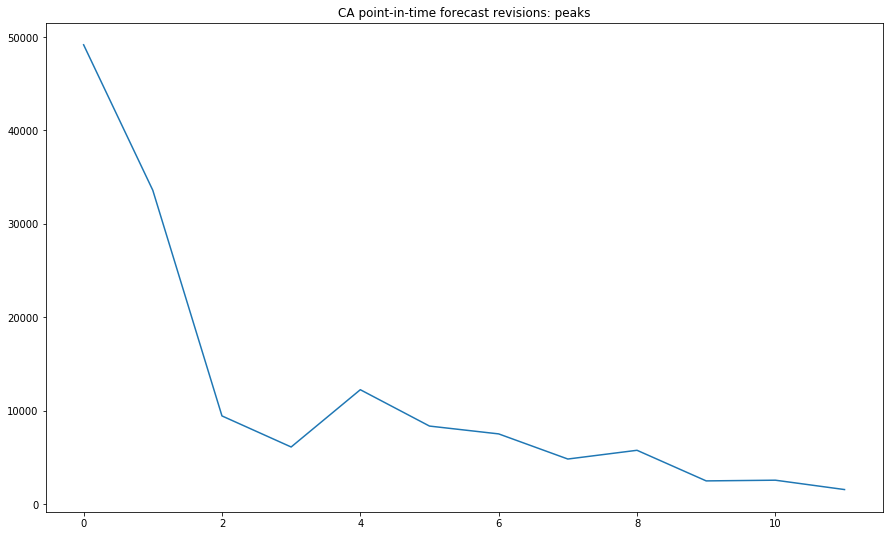

In [224]:
plt.figure(figsize=(15,9))
plt.title('CA point-in-time forecast revisions: peaks')
plt.plot(ca_peaks)
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

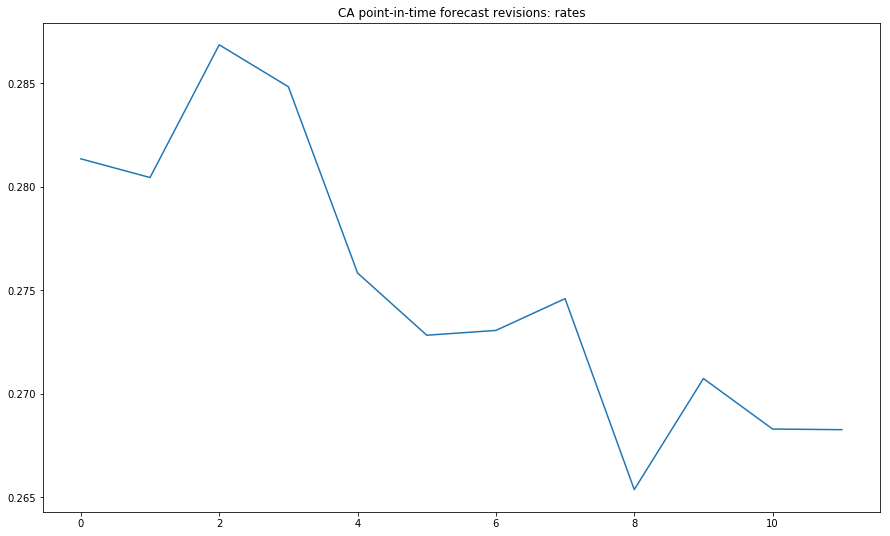

In [225]:
plt.figure(figsize=(15,9))
plt.title('CA point-in-time forecast revisions: rates')
plt.plot(ca_rates)
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

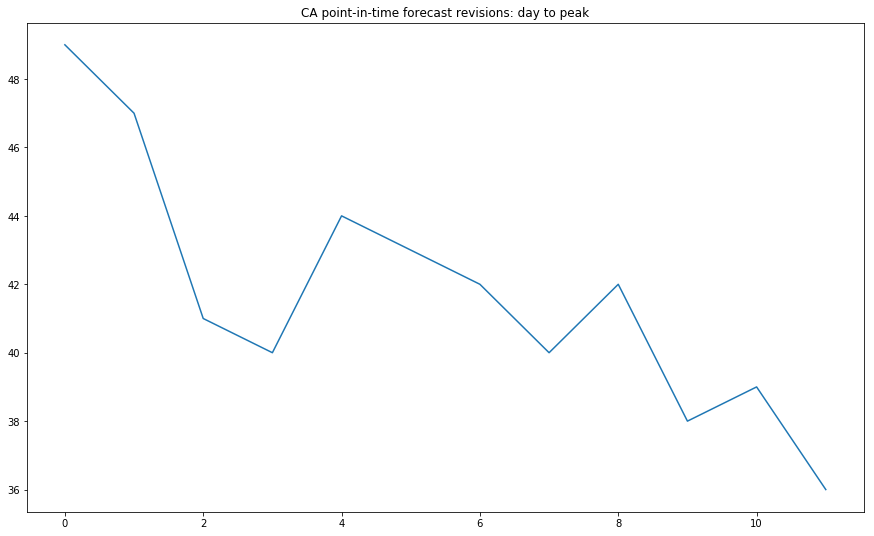

In [226]:
plt.figure(figsize=(15,9))
plt.title('CA point-in-time forecast revisions: day to peak')
plt.plot(ca_days)
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

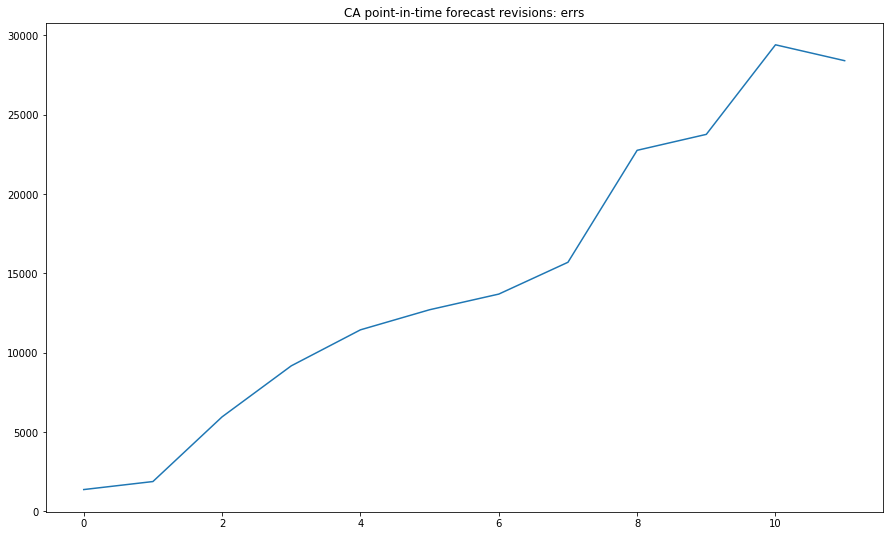

In [246]:
plt.figure(figsize=(15,9))
plt.title('CA point-in-time forecast revisions: errs')
plt.plot(np.array(ca_errs)/(len(cases_ca)-33))
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

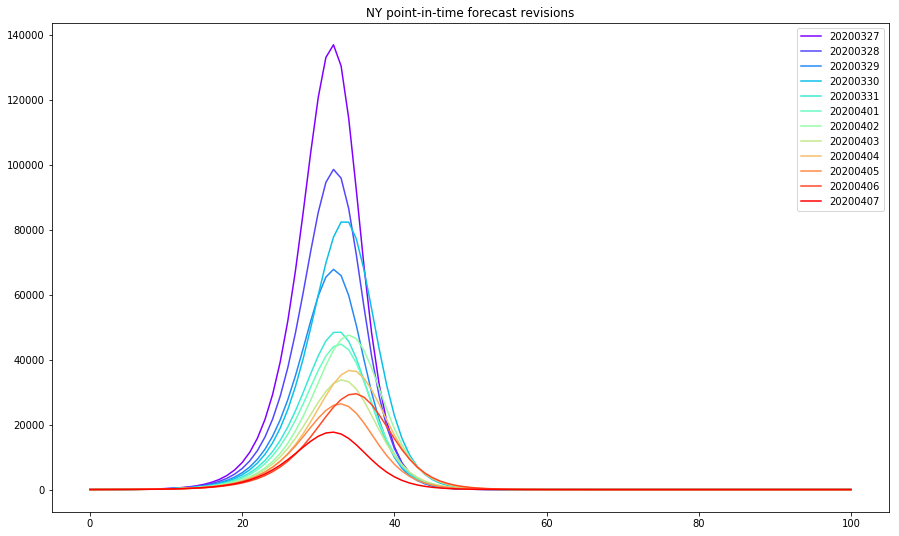

In [245]:
NUM_COLORS = len(ny_sims)
#cm = plt.get_cmap('gist_rainbow')
color=cm.rainbow(np.linspace(0,1,NUM_COLORS))

plt.figure(figsize=(15,9))
plt.title('NY point-in-time forecast revisions')
for sm in range(len(ny_sims)):
    lbl=files[sm].split('/')[-3]
    plt.plot(ny_sims[sm],label=lbl,c=color[sm])
plt.legend()
plt.show()

We can see that as we gather more data over time, projections over total population infected and peak infection have significantly decreased, indicating that stay-at-home measures are indeed 'flattening the curve'

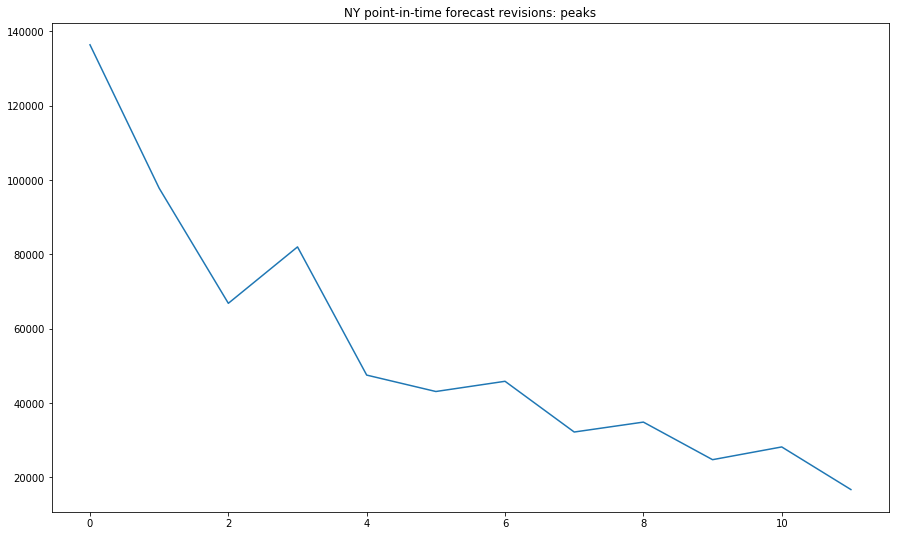

In [229]:
plt.figure(figsize=(15,9))
plt.title('NY point-in-time forecast revisions: peaks')
plt.plot(ny_peaks)
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

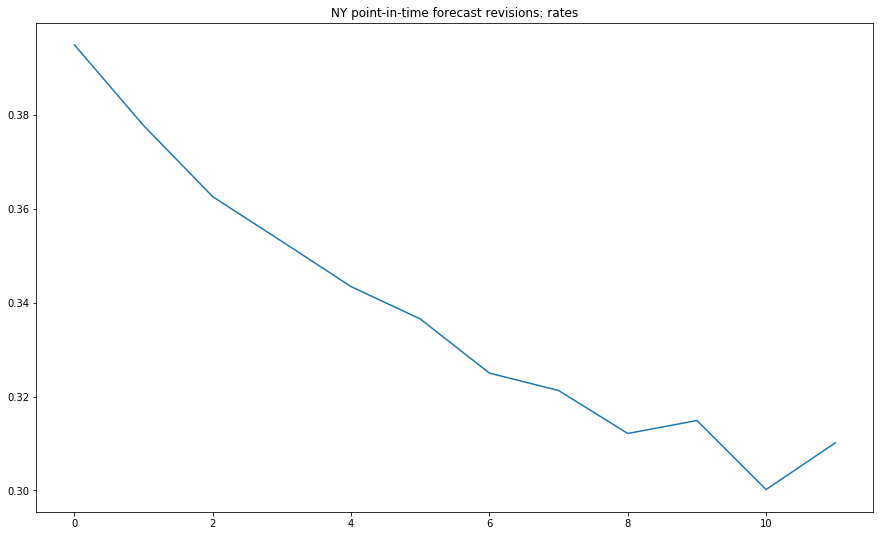

In [230]:
plt.figure(figsize=(15,9))
plt.title('NY point-in-time forecast revisions: rates')
plt.plot(ny_rates)
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

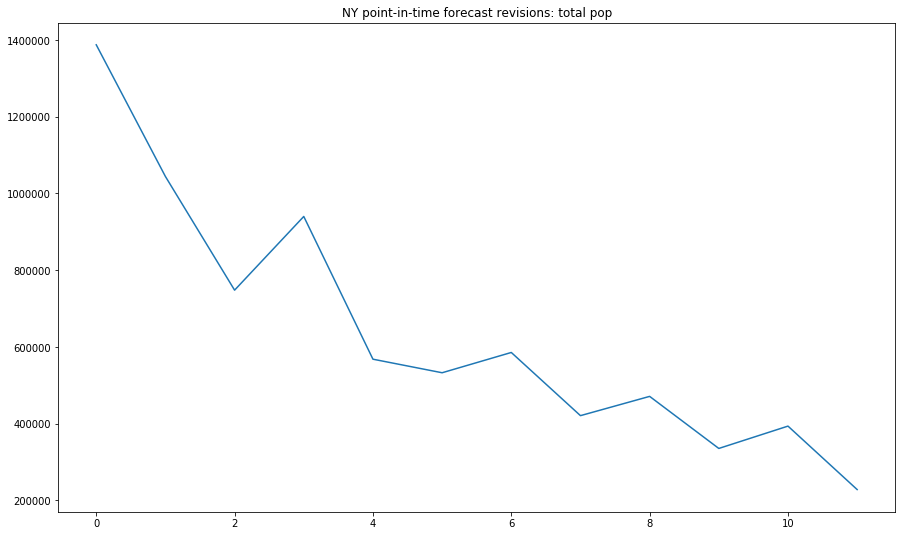

In [231]:
plt.figure(figsize=(15,9))
plt.title('NY point-in-time forecast revisions: total pop')
plt.plot(ny_pops)
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

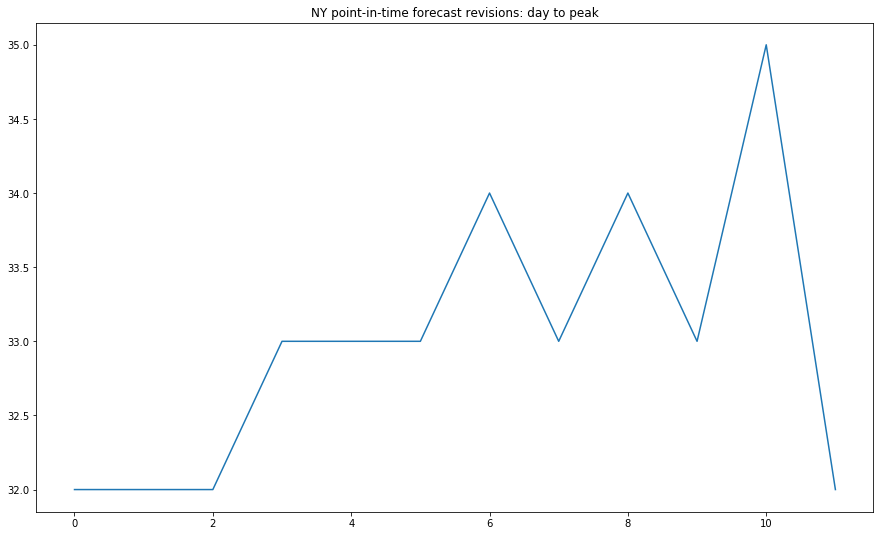

In [232]:
plt.figure(figsize=(15,9))
plt.title('NY point-in-time forecast revisions: day to peak')
plt.plot(ny_days)
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

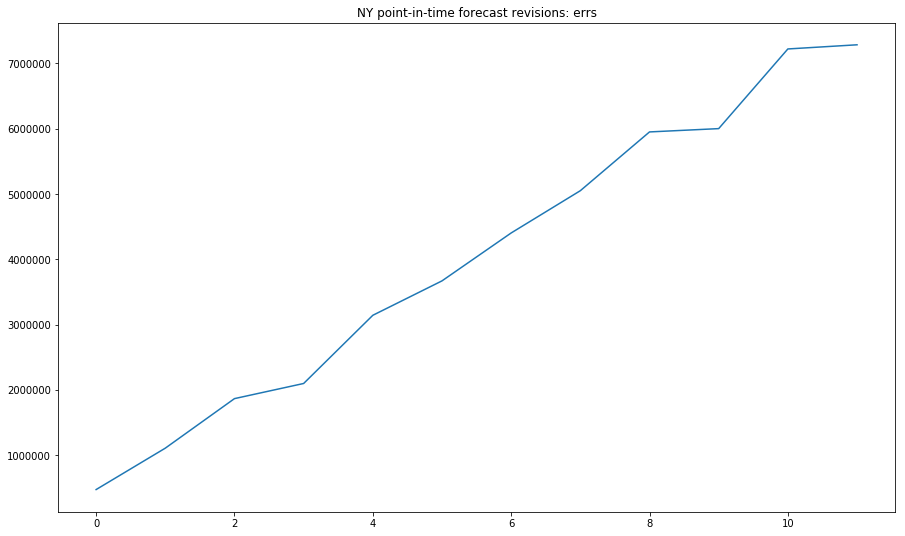

In [247]:
plt.figure(figsize=(15,9))
plt.title('NY point-in-time forecast revisions: errs')
plt.plot(np.array(ny_errs)/(len(cases_ny)-3))
#for sm in range(len(ca_sims)):
#    lbl=files[sm].split('/')[-3]
#    plt.plot(ca_sims[sm],label=lbl,c=color[sm])
#plt.legend()
plt.show()

In [266]:
#the error grows linearly, but we haven't normalized the error by number of datapoints
#the error grows linearly, but the datapoints grow exponentially
#at each point the forecasts are accurate to at least 90% of each datapoint. So when datapoints get up to 10000, error will add up to be about +(1000**2) = +(1000000)

In [ ]:
#TODO: how to pick how many starting points to discard?
#TODO: how to pick penalty parameter on total population size?
#Cross validation here won't work, it's a time series where points are non iid, do not follow a stationary distribution
#have to resort to online learning techniques based on regret minimization

In [215]:
#TODO: show error of chosen model over time for each state

In [ ]:
try fitting parameters instead using this example:
    https://people.duke.edu/~ccc14/sta-663/CalibratingODEs.html
using this algorithm:
    http://people.duke.edu/~hpgavin/ce281/lm.pdf
    Levenberg-Marquardt algorithm
    alternates between gradient descent and Gauss-Newton method
    non-linear least squares optimization

In [ ]:
assess quality of hypothesis+optimization algo using external regret
sum_t(L(h_today(x_t),y_t))-sum_t(L(h_t(x_t),y_t))

In [ ]:
track external regret over time for chosen hypothesis+optimization algo
each strategy=(hypothesis+optimization algo)
choose between strategies using regret minimization

In [ ]:
also try out the logistic model and a couple of other models:
    https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf

### Fitting a Sigmoid

In [271]:
def sigmoid(x,params):
     return (params[0]) / (1 + params[1]*np.exp(-params[2]*x))

In [264]:
Math(r'f(x)=\frac{L}{1+Ae^{-bx}}')

<IPython.core.display.Math object>

In [275]:
from scipy.optimize import leastsq

In [419]:
x0 = np.array([400000.0,200.0,0.13])

In [420]:
def residuals(coeffs,y,x):
    preds=[]
    for i in x:
        res=sigmoid(i,coeffs)
        preds.append(res)
    return y - np.array(preds)

In [436]:
def do_thing(fname='us-states.csv',plotting=True):
    cases_dict={}
    deaths_dict={}
    flips_dict={}
    
    with open(fname,'r') as fl:
        country_reader=csv.reader(fl)
        for row in country_reader:
            if row[1] not in cases_dict:
                cases_dict[row[1]]=[]
                deaths_dict[row[1]]=[]
                flips_dict[row[1]]=[]
            cases_dict[row[1]].append((row[0],row[3]))
            deaths_dict[row[1]].append((row[0],row[4]))
            flips_dict[row[1]].append((row[0],row[2]))
            
    days_ca=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['California']]
    cases_ca=[int(x[1]) for x in cases_dict['California']]
    days_ny=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New York']]
    cases_ny=[int(x[1]) for x in cases_dict['New York']]
    days_wa=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['Washington']]
    cases_wa=[int(x[1]) for x in cases_dict['Washington']]
    days_la=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['Louisiana']]
    cases_la=[int(x[1]) for x in cases_dict['Louisiana']]
    days_nj=[ datetime.datetime.strptime(x[0],'%Y-%m-%d').date() for x in cases_dict['New Jersey']]
    cases_nj=[int(x[1]) for x in cases_dict['New Jersey']]
    
    start_date_ca=cases_dict['California'][0][0]
    start_date_ny=cases_dict['New York'][0][0]
    
    input_data_ca_days=[ date_to_days(start_date_ca,x[0]) for x in cases_dict['California']][0:]
    input_data_ny_days=[ date_to_days(start_date_ny,x[0]) for x in cases_dict['New York']][0:]
    
    y_ca = cases_ca[33:]
    x_ca = input_data_ca_days[33:]
    x_ca = [i - 33 for i in x_ca]
    
    cases_ny_sub = [x-0 for x in cases_ny[0:]]#cases_ny[1] for x in cases_ny]
    y_ny = cases_ny_sub[3:]

    x_ny = input_data_ny_days[3:]
    x_ny = [i - 3 for i in x_ny]
    
    
    x_params_ca, flag = leastsq(residuals, x0, args=(y_ca, x_ca))
    
    x_ca_copy=x_ca.copy()
    for i in range(10):
        x_ca_copy.append(x_ca_copy[-1]+1)
        
    y_preds_ca=[ sigmoid(i,x_params_ca) for i in x_ca_copy]

    def make_plots(y_preds,y_act,state='CA'):
        plt.figure(figsize=(15,9))
        plt.subplot(221)
        plt.title(state+" sigmoid cumulative fit")
        plt.plot(y_preds,label='sigmoid')
        #print(x)
        plt.plot(y_act,label='actual')
        plt.legend()
        #plt.show()

        plt.subplot(222)
        plt.title(state+" sigmoid daily new cases fit")
        #y_preds_ca=[ sigmoid(i,x) for i in x_ca_copy]
        plt.plot(np.diff(y_preds),label='sigmoid')
        #print(x)
        plt.plot(np.diff(y_act),label='actual')
        plt.legend()
        plt.show()
    
    if plotting==True:
        make_plots(y_preds_ca,y_ca)
    
    x_ca_copy=x_ca.copy()
    for i in range(150):
        x_ca_copy.append(x_ca_copy[-1]+1)
    y_preds_ca=[ sigmoid(i,x_params_ca) for i in x_ca_copy]
    
    if plotting==True:
        make_plots(y_preds_ca,y_ca)


    x_params_ny, flag = leastsq(residuals, x0, args=(y_ny, x_ny))
    
    x_ny_copy=x_ny.copy()
    for i in range(10):
        x_ny_copy.append(x_ny_copy[-1]+1)
        
    y_preds_ny=[ sigmoid(i,x_params_ny) for i in x_ny_copy]
    
    if plotting==True:
        make_plots(y_preds_ny,y_ny,state='NY')
    
    x_ny_copy=x_ny.copy()
    for i in range(150):
        x_ny_copy.append(x_ny_copy[-1]+1)
    y_preds_ny=[ sigmoid(i,x_params_ny) for i in x_ny_copy]
    
    if plotting==True:
        make_plots(y_preds_ny,y_ny,state='NY')
    
    return x_params_ca,x_params_ny,y_preds_ca,y_preds_ny


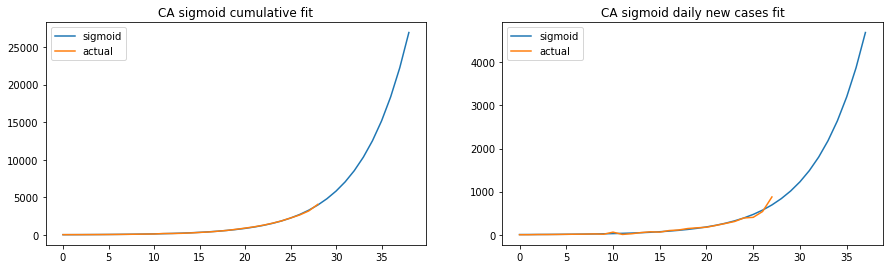

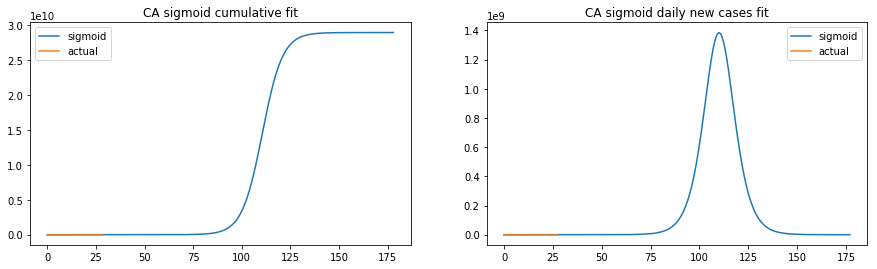

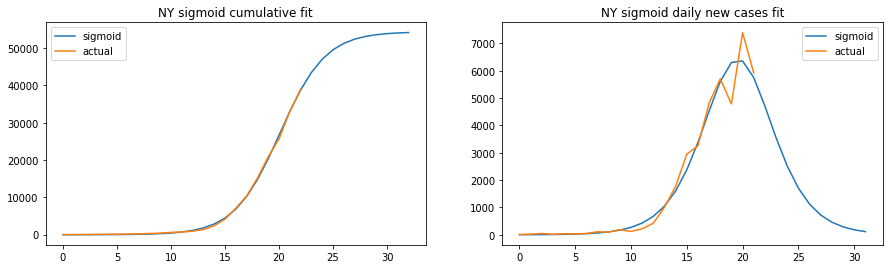

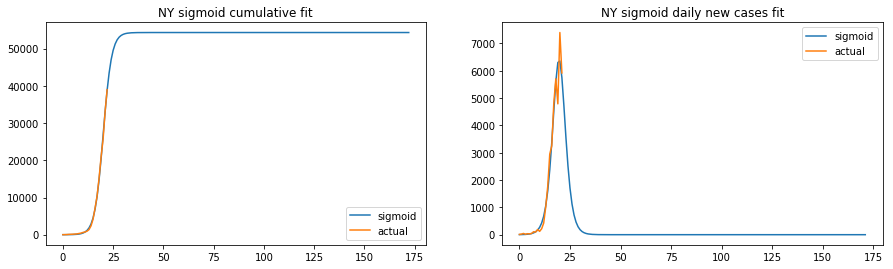

In [432]:
caparams,nyparams,y_preds_ca,y_preds_ny=do_thing()

When we fit sigmoid to cumulative CA data, we get a good fit but unreasonably high projections for coronavirus cases.

When we fit cumulative NY data, we get a good fit, but unreasonably low projections for coronavirus cases. 

We might need to add a penalty term in the residuals.

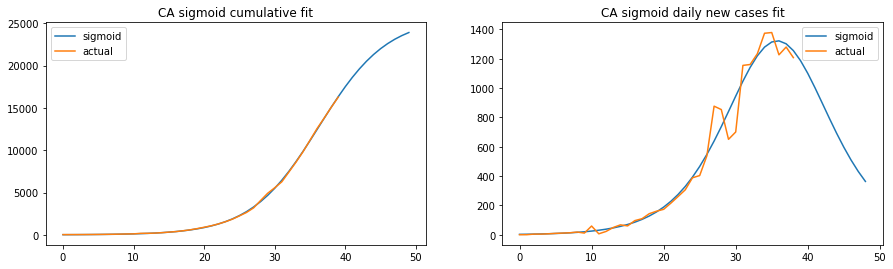

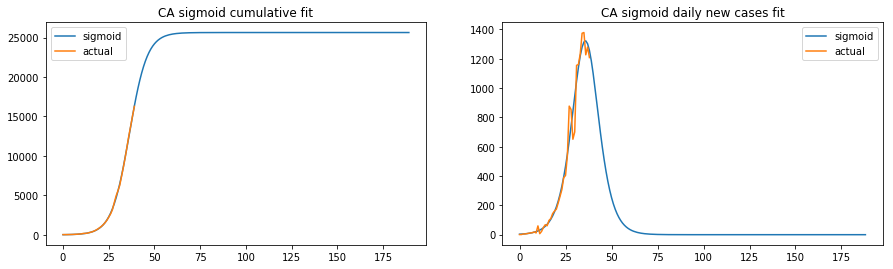

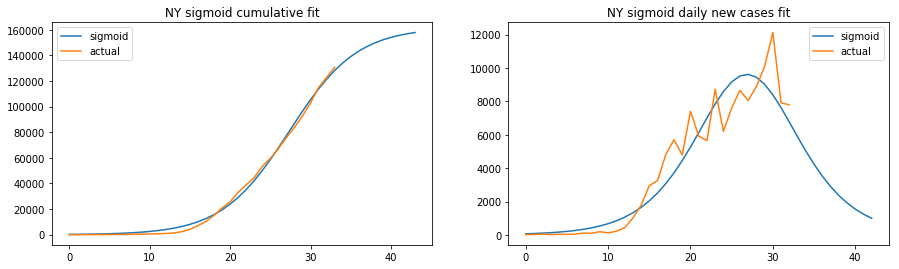

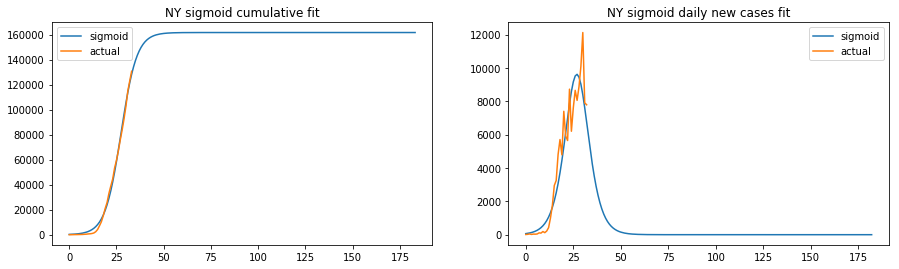

In [437]:
caparams,nyparams,y_preds_ca,y_preds_ny=do_thing('../../coronavirus_repo_vjain3/covid19_exploration/20200407/covid-19-data/us-states.csv')

We seem to get good cumulative fits, but that doesn't necessarily reflect good fits in daily cases

Can we quantify the quality of forecasts from the ODE and sigmoid model?

What process can we used to select between different models and hyperparameters? (regret minimization)

(The errors from ode are the values from objective function with the penalty.)

Do we use mean squared error? regret? percentage difference between forecasts and datapoints?

In [448]:
ca_preds=[]
ny_preds=[]
for fl in files:
    caparams,nyparams,y_preds_ca,y_preds_ny=do_thing(fl,plotting=False)
    ca_preds.append(y_preds_ca)
    ny_preds.append(y_preds_ny)

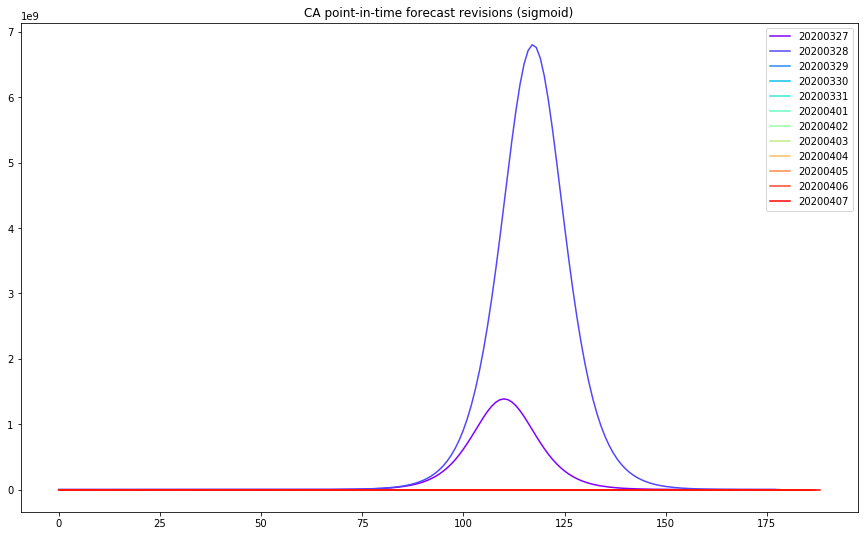

In [455]:
NUM_COLORS = len(ca_preds)
#cm = plt.get_cmap('gist_rainbow')
color=cm.rainbow(np.linspace(0,1,NUM_COLORS))

plt.figure(figsize=(15,9))
plt.title('CA point-in-time forecast revisions (sigmoid)')
for sm in range(0,len(ca_preds)):
    lbl=files[sm].split('/')[-3]
    plt.plot(np.diff(ca_preds[sm]),label=lbl,c=color[sm])
plt.legend()
plt.show()

The first two CA forecasts were severely overestimated. But after the forecasts were underestimating projections, so they were escalated with each new day.

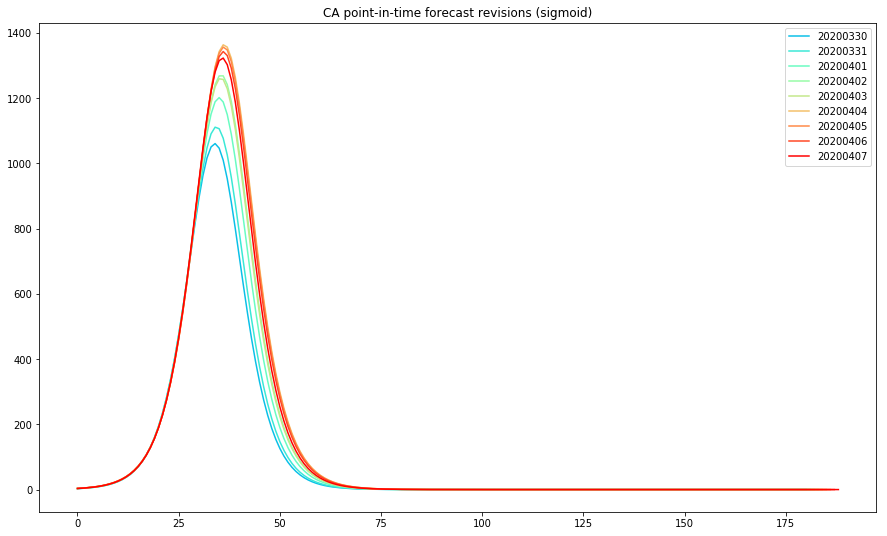

In [456]:
NUM_COLORS = len(ca_preds)
#cm = plt.get_cmap('gist_rainbow')
color=cm.rainbow(np.linspace(0,1,NUM_COLORS))

plt.figure(figsize=(15,9))
plt.title('CA point-in-time forecast revisions (sigmoid)')
for sm in range(3,len(ca_preds)):
    lbl=files[sm].split('/')[-3]
    plt.plot(np.diff(ca_preds[sm]),label=lbl,c=color[sm])
plt.legend()
plt.show()

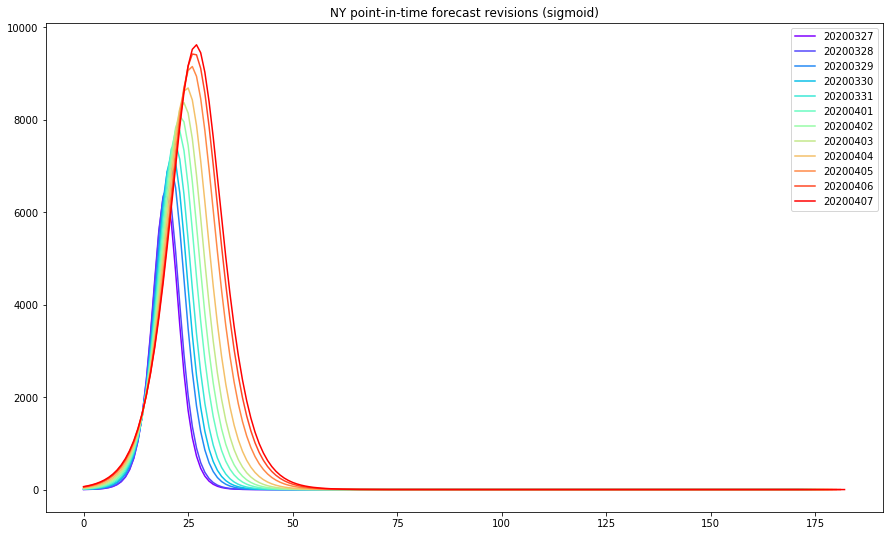

In [457]:
NUM_COLORS = len(ny_preds)
#cm = plt.get_cmap('gist_rainbow')
color=cm.rainbow(np.linspace(0,1,NUM_COLORS))

plt.figure(figsize=(15,9))
plt.title('NY point-in-time forecast revisions (sigmoid)')
for sm in range(len(ny_preds)):
    lbl=files[sm].split('/')[-3]
    plt.plot(np.diff(ny_preds[sm]),label=lbl,c=color[sm])
plt.legend()
plt.show()

NY forecasts were underestimating projections, so they were escalated with each new day.